In [1]:
# Get bitcoin data from GeckoAPI
from pycoingecko import CoinGeckoAPI
from datetime import datetime 

import numpy as np
import pandas as pd

# API wrapper
cg = CoinGeckoAPI()

# Get previous prices (1 yr + 1 day)
data = cg.get_coin_market_chart_by_id(id='bitcoin', vs_currency='usd', days='366', interval='daily')
prices = data['prices']
total_vols = data['total_volumes']

df = pd.DataFrame()
df['Date'] = pd.DataFrame(prices)[0]
df['Price'] = pd.DataFrame(prices)[1]
df['Total_Vols'] = pd.DataFrame(total_vols)[1]
df

,Date,Price,Total_Vols
0,1590883200000,9662.705873,3.023149e+10
1,1590969600000,9466.961781,2.739666e+10
2,1591056000000,10167.930693,3.370254e+10
3,1591142400000,9515.243859,3.684115e+10
4,1591228800000,9645.227869,2.522203e+10
...,...,...,...
362,1622160000000,38642.895554,4.083682e+10
363,1622246400000,35710.220937,4.999159e+10
364,1622332800000,34775.079413,4.318403e+10
365,1622419200000,35714.752020,3.065027e+10


In [2]:
# Clean data format
# Unix timestamp -> utc format
df['Date'] = df['Date'].apply(lambda x: datetime.utcfromtimestamp(int(x) / 1000).strftime('%Y-%m-%d'))

# Show only 2 decimals (will not modify actual value)
pd.options.display.float_format = "{:,.2f}".format
df

,Date,Price,Total_Vols
0,2020-05-31,"9,662.71","30,231,487,421.64"
1,2020-06-01,"9,466.96","27,396,663,221.15"
2,2020-06-02,"10,167.93","33,702,539,853.51"
3,2020-06-03,"9,515.24","36,841,150,778.64"
4,2020-06-04,"9,645.23","25,222,025,158.96"
...,...,...,...
362,2021-05-28,"38,642.90","40,836,817,155.72"
363,2021-05-29,"35,710.22","49,991,590,067.74"
364,2021-05-30,"34,775.08","43,184,025,044.77"
365,2021-05-31,"35,714.75","30,650,274,657.70"


In [3]:
# Create new column indicating price change from previous day
df['Difference'] = df['Price'] - df['Price'].shift(periods = 1)

# Drop the 0th row (it has no previous data)
df = df.dropna()
df = df.reset_index(drop = True)

# Boolean value of whether price whent up.
# 0 change is considered 'up', since there will be no loss of profit.
df['Up'] = df['Difference'].apply(lambda x: True if x >= 0 else False)

df

,Date,Price,Total_Vols,Difference,Up
0,2020-06-01,"9,466.96","27,396,663,221.15",-195.74,False
1,2020-06-02,"10,167.93","33,702,539,853.51",700.97,True
2,2020-06-03,"9,515.24","36,841,150,778.64",-652.69,False
3,2020-06-04,"9,645.23","25,222,025,158.96",129.98,True
4,2020-06-05,"9,776.20","24,903,069,188.40",130.98,True
...,...,...,...,...,...
361,2021-05-28,"38,642.90","40,836,817,155.72",-764.04,False
362,2021-05-29,"35,710.22","49,991,590,067.74","-2,932.67",False
363,2021-05-30,"34,775.08","43,184,025,044.77",-935.14,False
364,2021-05-31,"35,714.75","30,650,274,657.70",939.67,True


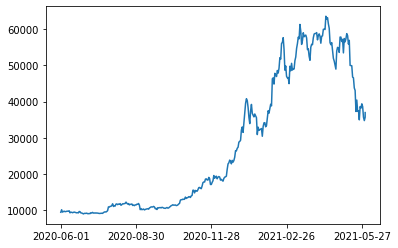

In [4]:
# Overview of price
import matplotlib.pyplot as plt

plt.plot(df['Date'], df['Price'])
plt.xticks(np.arange(0, len(df['Date']) - 1, 90))
plt.show()

In [5]:
# Create KNN algorithm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

X = df[['Price', 'Total_Vols', 'Difference']]
Y = df['Up']

# Split training and testing data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True)

In [6]:
# Train KNN
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

# Make prediction & measure accuracy in percentages
acc_train = accuracy_score(y_train, knn.predict(x_train)) * 100
acc_test = accuracy_score(y_test, knn.predict(x_test)) * 100

In [7]:
# Show model metrics
print(f'Training data accuracy : {acc_train:.2f} %')
print(f'Test data accuracy : {acc_test:.2f} %')

Training data accuracy : 71.09 %
Test data accuracy : 46.36 %
